# Full Pipeline Extractive Text Summarization

Full pipeline for extractive summarisation of Euan's Guide accessibility reviews with aspect and sentiment features.

Steps of the pipeline:


1.   Set-up of notebook and install required packages
2.   Load datasets
3.   Train and Test data split
4.   Text cleaning
5.   Exploratory Data Analysis
6.   Pre-processing for classification
7.   Aspect Classification
     *   Classical Machine Learning
     *   Unsupervised Model
     *   BERT (pre-trained, fine-tuned)
8.   Sentiment Analysis
     *   Classical Machine Learning
     *   Unsupervised Model
     *   BERT
9.   Topic Summarisation
     *   TextRank (Gensim)
     *   BERT (Summarizer, distil, sentence)
     *   Evaluation

In [84]:
import sys
print(sys.version)
# print(sys.modules['python'])

3.9.5 (v3.9.5:0a7dcbdb13, May  3 2021, 13:05:53) 
[Clang 12.0.5 (clang-1205.0.22.9)]


# Set-up

In [85]:
# CD to correct folder 
! cd "/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/Lizzie's Code"

# Initialize path
import sys
sys.path.append('')


In [86]:
%%capture
# modules to download
# %python -m spacy download en_core_web_lg
# %pip show ipykernel
# %pip install tabulate
# %pip install datasets
# %pip install torch
# %pip install nltk
# %pip install matplotlib
# %pip install seaborn
# %pip install scikit-learn
# %pip install scipy
# %pip import spacy


In [87]:
%%capture
# Import packages
# Import general packages
import pandas as pd
import numpy as np

from pprint import pprint
from tabulate import tabulate
import random
import time
from datasets import load_metric

# Torch
import torch
import torch.nn as nn
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from torch.optim import Adam

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from scipy import spatial

# Regex
import re

# NLTK
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# MatplotLib
import matplotlib
import matplotlib.pyplot as plt

# Seaborn
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

# Sklearn
import sklearn
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.metrics import plot_confusion_matrix
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import utils

# Spacy
import spacy
import en_core_web_lg

# Transformers and BERT
import transformers
from transformers import BertTokenizer
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
from summarizer import Summarizer
from summarizer.sbert import SBertSummarizer

# Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from gensim.summarization.textcleaner import get_sentences, split_sentences
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim.matutils import kullback_leibler

# Functions
class color:
      PURPLE = '\033[95m'
      CYAN = '\033[96m'
      DARKCYAN = '\033[36m'
      BLUE = '\033[94m'
      GREEN = '\033[92m'
      YELLOW = '\033[93m'
      RED = '\033[91m'
      BOLD = '\033[1m'
      UNDERLINE = '\033[4m'
      END = '\033[0m'

# Loading the dataset

In [88]:
# ---------- READ ALL REVIEWS ----------
import glob
import os
import pandas as pd

path = "/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/Lizzie's Code"

# Define path and files
path_google_reviews = path+"/GoogleReviews"
all_files = glob.glob(path_google_reviews + "/*.csv")

# Count number of venues in path
file_count = 0
dir = path_google_reviews
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        file_count += 1

print("All_files:", len(all_files))
print("File_Count:", file_count)

# Create a list with all the data names
data_names = []

for i in range(file_count):
    data_names.append("data"+str(i))

# Create empty list
dataframes_list = []
# append datasets to the list
for file in all_files:
    temp_df = pd.read_csv(file)
    temp_df = temp_df.drop(columns="Unnamed: 0")
    dataframes_list.append(temp_df)
# Define path to save the summaries
path_summaries = path + "/Results"

All_files: 1948
File_Count: 1950


In [89]:
# Example Review DataFrame
dataframes_list[1945].head()

,Name,Review Rate,Review Time,Review Text
0,Coffeeshop Betty Boop,5 stars,2 years ago,"Sitting in the first floor, smoke and being ab..."
1,Coffeeshop Betty Boop,5 stars,8 months ago,Love the new Easy Times location. Much smaller...
2,Coffeeshop Betty Boop,2 stars,4 years ago,It was better under previous management. Both ...
3,Coffeeshop Betty Boop,5 stars,5 months ago,"best coffeshop, very patient and nice staff, I..."
4,Coffeeshop Betty Boop,5 stars,5 months ago,"Great first experience, amazing and helpful staff"


# Cleaning the dataset

In [90]:
def cleaning_df(df):
    
    # ========= CLEAN DATA =========
    color.BOLD
    print(color.BOLD + "---> START CLEANING" + color.END) 
    # Rename and drop colums
    df = df.drop(columns=["Review Time"])
    df = df.rename(columns={"Review Text": "Text", "Review Rate": "Sentiment"})

    # Drop NaN
    df = df[df["Text"].notna()]
    df["Text"] = df["Text"].apply(lambda x: x.replace("\n", ' '))

    # Drop reviews with a rating of 0 (rating is missing)
    df = df[df["Sentiment"]!="0 stars"]

    # Tokenize into sentences: regEX
    rule = r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s"
    df["Text"] = df["Text"].apply(lambda x: re.split(rule, x))
    df = df.explode("Text", ignore_index=True)
    df = df[df["Text"].notna()]
    df = df[df['Text']!='']

    df["Sentiment"] = df["Sentiment"].map(lambda x: re.sub(" stars", "", x))
    df["Sentiment"] = df["Sentiment"].map(lambda x: re.sub(" star", "", x))
    df["Sentiment"] = df["Sentiment"].map(lambda x: int(x))

    # Rating into Sentiment
    df["Sentiment"] = df["Sentiment"].map(lambda score: 'positive' if score > 3 else 'negative')
    df['Label'] = df["Sentiment"].map({'positive': 1, 'negative': 0})

    print("---> DONE CLEANING")
    return df

In [91]:
# ========= CLEAN DATA =========
cleaned_reviews = []
for df in dataframes_list:            # Remove [:5] to clean all reviews in the dataframes_list
  cleaned_reviews.append(cleaning_df(df))

---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> DONE CLEANING
---> START CLEANING
---> 

In [92]:
# Preview of Cleaned Review
cleaned_reviews[0].head()

,Name,Sentiment,Text,Label
0,Ellis,positive,"It was a bit quite when we went in, but don’t ...",1
1,Ellis,positive,Rightfully so! The burgers (and nachos) were l...,1
2,Ellis,positive,I would definitely recommend this place if you...,1
3,Ellis,positive,Nice cozy place which serves very tasty burger...,1
4,Ellis,positive,They have a good selection of burgers and othe...,1


## Train/Test Split

In [93]:
training_path = "/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/Lizzie's Code/EuansGuideData.xlsx"
# Concatenate the google reviews into one file 
test_path = "/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/Lizzie's Code/GoogleReviews"

In [94]:
import pandas as pd
import glob

google_reviews_path =r"/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/Lizzie's Code/GoogleReviews" # use your path
all_files = glob.glob(google_reviews_path + "/*.csv")
# for name in all_files[-10:-1]:
#     print(name)
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)


In [95]:
frame = frame.drop("Unnamed: 0", axis=1)


In [96]:
frame

,Name,Review Rate,Review Time,Review Text
0,Ellis,5 stars,3 years ago,"It was a bit quite when we went in, but don’t ..."
1,Ellis,5 stars,2 years ago,Nice cozy place which serves very tasty burger...
2,Ellis,5 stars,3 years ago,Really nice place. One of my favourite burger ...
3,Ellis,2 stars,3 years ago,The Service was quite good but the burgers we ...
4,Ellis,5 stars,2 years ago,I had a very nice experience! The staff were r...
...,...,...,...,...
577525,Amstelhoeck,4 stars,3 years ago,NaN
577526,Amstelhoeck,5 stars,4 years ago,NaN
577527,Amstelhoeck,4 stars,3 years ago,NaN
577528,Amstelhoeck,3 stars,3 years ago,NaN


In [97]:
# ---------- TRAIN & TEST DATA ----------
# Count how much training data you have relative to test data before you split to train.
train_data = pd.read_excel(training_path)
test_data = frame
train_data

,Aspect,Rating,Review,City,Country,Venue
0,Overview,5.0,Dobbies garden center has a large range of ite...,Perth,United Kingdom,https:||www.euansguide.com|venues|dobbies-gard...
1,Transport & Parking,5.0,"There is disabled parking close to the doors, ...",Perth,United Kingdom,https:||www.euansguide.com|venues|dobbies-gard...
2,Access,5.0,There is a lift and there is also a cafe where...,Perth,United Kingdom,https:||www.euansguide.com|venues|dobbies-gard...
3,Toilets,0.0,NaN,Perth,United Kingdom,https:||www.euansguide.com|venues|dobbies-gard...
4,Staff,3.5,There were some staff who were very helpful an...,Perth,United Kingdom,https:||www.euansguide.com|venues|dobbies-gard...
...,...,...,...,...,...,...
85301,Staff,-2.0,Information about the staff has not been added...,Johnstone,United Kingdom,https:||www.euansguide.com|venues|trattoria-ro...
85302,COVID Precautions,-2.0,Information about COVID precautions has not be...,Johnstone,United Kingdom,https:||www.euansguide.com|venues|trattoria-ro...
85303,Accessibility,-2.0,A description about the access has not been ad...,Bletchley,United Kingdom,https:||www.euansguide.com|venues|bletchley-pa...
85304,Toilets,-2.0,Information about the toilets has not been add...,Bletchley,United Kingdom,https:||www.euansguide.com|venues|bletchley-pa...


In [98]:
# Redo the code in this cell as the file paths do not apply to your machine.

train_data_cleaned = pd.read_csv(training_path + 'train_data_cleaned.csv').drop('Unnamed: 0', axis=1) #0: 55920, 1: 1550
val_data_cleaned = pd.read_csv(training_path + 'val_data_cleaned.csv').drop('Unnamed: 0', axis=1)
test_data_cleaned = pd.read_csv(training_path + 'test_data_cleaned.csv').drop('Unnamed: 0', axis=1) #0: 6977, 1: 2395

total_train_data = pd.concat([train_data_cleaned, val_data_cleaned])

X_train= pd.read_csv(training_path + 'X_train.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 55920, 1: 1550
y_train_aspect = pd.read_csv(training_path + 'y_train_aspect.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 6977, 1: 2395
y_train_sent = pd.read_csv(training_path + 'y_train_sent.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 55920, 1: 1550

X_val = pd.read_csv(training_path + 'X_val.csv').rename(columns={"Unnamed: 0": "Index"})
y_val_aspect = pd.read_csv(training_path + 'y_val_aspect.csv').rename(columns={"Unnamed: 0": "Index"})
#y_val_target = pd.read_csv(path + 'y_train_sent.csv').rename(columns={"Unnamed: 0": "Index"})
y_val_sent = pd.read_csv(training_path + 'y_val_sent.csv').rename(columns={"Unnamed: 0": "Index"})

X_test = pd.read_csv(training_path + 'X_test.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 6977, 1: 2395
y_test_aspect = pd.read_csv(training_path + 'y_test_aspect.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 55920, 1: 1550
y_test_sent = pd.read_csv(training_path + 'y_test_sent.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 6977, 1: 2395

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/myenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/qk/lcnvt9x13sd1_944mzdqthnh0000gn/T/ipykernel_41348/2583416073.py", line 3, in <module>
    train_data_cleaned = pd.read_csv(training_path + 'train_data_cleaned.csv').drop('Unnamed: 0', axis=1) #0: 55920, 1: 1550
  File "/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/myenv/lib/python3.9/site-packages/pandas/util/_decorators.py", line 211, in wrapper
  File "/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/myenv/lib/python3.9/site-packages/pandas/util/_decorators.py", line 331, in wrapper
    return cast(F, wrapper)
  File "/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/myenv/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 950, in read_csv
  File

## Dictionaries for results

In [99]:
# ========= CREATE DICTIONARIES FOR RESULTS =========
results_text = dict()             # text classification results
results_sentiment = dict()        # sentiment analysis results
results_summary = dict()          # summary results

# EDA

In [100]:
df = pd.concat([train_data_cleaned, test_data_cleaned, val_data_cleaned])
len(df)
df.head()

NameError: name 'train_data_cleaned' is not defined

In [ ]:
print(val_data_cleaned)

       Index   Aspect  Rating  \
0      46278  Toilets     3.0   
1      46278  Toilets     3.0   
2      46278  Toilets     3.0   
3      46278  Toilets     3.0   
4      46278  Toilets     3.0   
...      ...      ...     ...   
53149   5644   Access     4.5   
53150   5644   Access     4.5   
53151  16368    Staff     4.0   
53152  16368    Staff     4.0   
53153  48658   Access     5.0   

                                                    Text  \
0      Accessible toilet had grab rails, low basin an...   
1                  All good till you come to the shower.   
2                Accessed by climbing into the low bath.   
3      Adjustable shower on the wall was far too high...   
4       We had to pull the red cord for help when my ...   
...                                                  ...   
53149  I got into most of the buildings,staff helped ...   
53150  Reason I didn’t give a 5  was a few areas the ...   
53151                                Staff were helpful.   
531

In [ ]:
print("NR. of sentences", len(df["Text"]))
print("NR of reviews", len(df["Index"].unique()))
print("NR. of venues", len(df["Venue"].unique()))
print("NR of aspects", len(df["Aspect"].unique()))

review_counts = df['Venue'].value_counts()

review_metrics = [["Total nr. of sentences:", review_counts.sum()], 
                    ["Max nr. of sentences per venue:", review_counts.max()], 
                    ["Min nr. of sentences per venue:", review_counts.min()], 
                    ["Average nr. of sentences per venue:", review_counts.mean()]]
col_names = ["Metric", "Count"]
print(tabulate(review_metrics, headers=col_names))

sentence_counts = df['Aspect'].value_counts()

sentence_metrics = [["Total nr. of sentence:", sentence_counts.sum()], 
                    ["Max nr. of sentence per aspect:", sentence_counts.max()], 
                    ["Min nr. of sentence per aspect:", sentence_counts.min()], 
                    ["Average nr. of sentence per aspect:", sentence_counts.mean()]]
col_names = ["Metric", "Count"]
print(tabulate(sentence_metrics, headers=col_names))

sentence_length = []
for i in df["Text"]:
    sentence_length.append(len(i))
import statistics
print("NR of words per sentence (average)", statistics.mean(sentence_length))
print("NR of words per sentence (max)", max(sentence_length))
print("NR of words per sentence (min)", min(sentence_length))


NR. of sentences 170193
NR of reviews 40024
NR. of venues 6413
NR of aspects 5
Metric                                     Count
-----------------------------------  -----------
Total nr. of sentences:              170193
Max nr. of sentences per venue:        1103
Min nr. of sentences per venue:           1
Average nr. of sentences per venue:      26.5387
Metric                                  Count
-----------------------------------  --------
Total nr. of sentence:               170193
Max nr. of sentence per aspect:       56072
Min nr. of sentence per aspect:       19657
Average nr. of sentence per aspect:   34038.6
NR of words per sentence (average) 88.36542631013026
NR of words per sentence (max) 1879
NR of words per sentence (min) 1


In [ ]:
# ========= EDA =========
print(color.BOLD + "---> START EDA" + color.END)

#====================
#=====PER ASPECT=====
#====================
print(color.BOLD + "REVIEWS PER ASPECT:" + color.END)
# Reviews
review_counts = df['Text'].value_counts()

review_metrics = [["Total nr. of reviews:", review_counts.sum()], 
                    ["Max nr. of reviews per aspect:", review_counts.max()], 
                    ["Min nr. of reviews per aspect:", review_counts.min()], 
                    ["Average nr. of reviews per aspect:", review_counts.mean()]]
col_names = ["Metric", "Count"]
print(tabulate(review_metrics, headers=col_names))

plt.figure(figsize=(8,4))
sns.barplot(review_counts.index, review_counts.values, alpha=0.8)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xlabel('Aspect', fontsize=12)
plt.ylim(0, 10000)

# Sentences per aspect
print(color.BOLD + "SENTENCES PER ASPECT:" + color.END)
sentence_counts = dict()
for aspect in df["Aspect"].unique():
    temp = df[df["Aspect"]==aspect]
    sentence_counts[aspect] = temp["SentenceCount"].mean()

print(color.BOLD + "Average nr. of sentences per aspect" + color.END)
pprint(sentence_counts)

# Sentences per review
print(color.BOLD + "SENTENCES PER REVIEW:" + color.END)
sentence_metrics = [["Total nr. of sentences:", df["SentenceCount"].sum()], 
                    ["Max nr. of sentences per review:", df["SentenceCount"].max()], 
                    ["Min nr. of sentences per review:", df["SentenceCount"].min()], 
                    ["Average nr. of sentences per review:", df["SentenceCount"].mean()]]
col_names = ["Metric", "Count"]
print(tabulate(sentence_metrics, headers=col_names))

---> START EDA
REVIEWS PER ASPECT:
Metric                                     Count
----------------------------------  ------------
Total nr. of reviews:               170193
Max nr. of reviews per aspect:         933
Min nr. of reviews per aspect:           1
Average nr. of reviews per aspect:       1.51244


TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 800x400 with 0 Axes>

In [ ]:
#====================
#=====PER VENUE=====
#====================
print(color.BOLD + "REVIEWS PER VENUE:" + color.END)
review_count_per_venue = df['Venue'].value_counts()

print(color.BOLD + "Review EDA:" + color.END)
review_metrics_per_venue = [["Total nr. of reviews:", int(review_count_per_venue.sum())], 
                            ["Max nr. of reviews per venue:", review_count_per_venue.max()], 
                            ["Min nr. of reviews per venue:", review_count_per_venue.min()], 
                            ["Average nr. of reviews per venue:", review_count_per_venue.mean()]]
col_names = ["Metric", "Count"]
print(tabulate(review_metrics_per_venue, headers=col_names))

In [ ]:
#====================
#=====PER RATING=====
#====================
print(color.BOLD + "REVIEWS PER RATING:" + color.END)
rating_counts = df['Rating'].value_counts()
plt.figure(figsize=(8,4))
ax = sns.barplot(rating_counts.index, rating_counts.values, alpha=0.8)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xlabel('Rating', fontsize=12)
plt.ylim(0, 16000)
plt.show();

print(color.BOLD + "REVIEWS PER SENTIMENT:" + color.END)
sentiment_count = df['Sentiment'].value_counts()
plt.figure(figsize=(8,4))
ax = sns.barplot(sentiment_count.index, sentiment_count.values, alpha=0.8)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.ylim(0, 35000)
plt.show();

In [ ]:
print("Number of venues:", len(train_data_cleaned["Venue"].unique()))
print("Number of venues:", len(test_data_cleaned["Venue"].unique()))

print("Total:", 16731 + 11325)

print("Number of reviews:", len(train_data["Review"]))
print("Number of reviews:", len(test_data["Review"]))

print("Total:", 16731 + 11325)

Number of venues: 16731
Number of venues: 11325
Total: 28056
Number of reviews: 68244
Number of reviews: 17062
Total: 28056


# Pre-processing

## Classical Machine Learning

In [ ]:
# ========= PRE-PROCESSING FOR MACHINE LEARNING MODELS =========
def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Remove URLs
    - Change "'t" to "not"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Remove URLs
    s = re.sub(r"http.*?(?=\s)", "", s) 
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

In [ ]:
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])

In [ ]:
# ========= PIPELINE WITH DOC2VEC =========
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

def doc2vec_preprocessing(text):
    text = str(text)
    text = text.lower()  
    text = text.replace("\n", '')                            # Remove \n
    text = re.sub("n’t", ' not', text)                       # Change n't to not
    text = re.sub("'re", ' are', text)                       # Change 're to are
    text = re.sub(r'[^\w\s]', '', text)                      # Remove punctuation
    text = re.sub(" +", " ", text)                           # Remove multiple spaces
    text = re.sub(r"http.*?(?=\s)", "", text)                # Remove URL's
    text = re.sub("'"," ", text)                             # Remove apostrophes

    return text

In [ ]:
# ========= VECTORIZATION WITH DOC2VEC =========
tqdm.pandas(desc="progress-bar")

X_train_doc2vec = [doc2vec_preprocessing(text) for text in X_train_preprocessed]
X_test_doc2vec = [doc2vec_preprocessing(text) for text in X_test_preprocessed]

print(color.BOLD + "Support Vector Machines with Doc2Vec" + color.END)
X_train_label = label_sentences(X_train_doc2vec, 'Train')
X_test_label = label_sentences(X_test_doc2vec, 'Test')
all_data = X_train_label + X_test_label

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train_label), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test_label), 300, 'Test')

Support Vector Machines with Doc2Vec


100%|██████████| 117039/117039 [00:00<00:00, 2853721.35it/s]


# Aspect Classification

## Classical Machine Learning

In [ ]:
len(X_train_preprocessed) # 93097
len(y_train_target)

93097

Multinomial Naive Bayes (tf-idf)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy:
0.6460613148442068
Weighted avg:
{'f1-score': 0.648451491196812,
 'precision': 0.6668988399759201,
 'recall': 0.6460613148442068,
 'support': 23942}
Balanced Accuracy: 0.6301281466662785
Multinomial Logistic Regression (tf-idf)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy:
0.6170745969426114
Weighted avg:
{'f1-score': 0.6163656971219,
 'precision': 0.6171645239333868,
 'recall': 0.6170745969426114,
 'support': 23942}
Balanced Accuracy: 0.6435605632552548


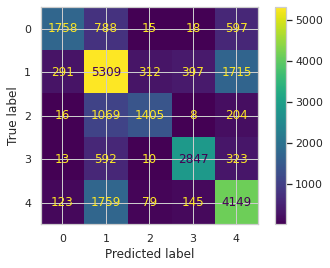

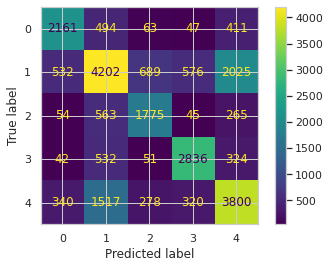

In [ ]:
#==============================
#===== TEST TF-IDF ML MODELS =====
#==============================

# MultinomialNB (alpha=1.0)
print(color.BOLD + "Multinomial Naive Bayes (tf-idf)" + color.END)
nb = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=1.0))
                ])
nb.fit(X_train_preprocessed, y_train_target)
y_pred = nb.predict(X_test_preprocessed)
plot_confusion_matrix(nb, X_test_preprocessed, y_test_target)
#Get the confusion matrix
#cf_matrix_mnb = confusion_matrix(y_test_target, y_pred)

metrics_nb = classification_report(y_test_target, y_pred, output_dict=True) #y_true, y_pred
results_text["NB(tfidf)"] = metrics_nb
print("Accuracy:")
pprint(results_text["NB(tfidf)"]['accuracy'])
print("Weighted avg:")
pprint(results_text["NB(tfidf)"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test_target, y_pred))

# Multinomial Logistic Regression
print(color.BOLD + "Multinomial Logistic Regression (tf-idf)" + color.END)
logreg = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(multi_class='multinomial', n_jobs=1, C=1e5, solver='sag'))
                ])
logreg.fit(X_train_preprocessed, y_train_target)
y_pred = logreg.predict(X_test_preprocessed)
plot_confusion_matrix(logreg, X_test_preprocessed, y_test_target)
#cf_matrix_mlr = confusion_matrix(y_test_target, y_pred)

metrics_logreg = classification_report(y_test_target, y_pred, output_dict=True)
results_text["LogReg(tfidf)"] = metrics_logreg
print("Accuracy:")
pprint(results_text["LogReg(tfidf)"]['accuracy'])
print("Weighted avg:")
pprint(results_text["LogReg(tfidf)"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test_target, y_pred))

Support Vector Machines (tf-idf)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy:
0.6771781806031242
Weighted avg:
{'f1-score': 0.677746184055407,
 'precision': 0.6784504744799548,
 'recall': 0.6771781806031242,
 'support': 23942}
Balanced Accuracy: 0.6989579160008519


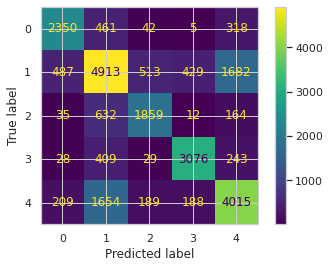

In [ ]:
# Support Vector Machines (kernel=linear)
print(color.BOLD + "Support Vector Machines (tf-idf)" + color.END)
clf = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', svm.SVC(kernel='linear'))
                ])
clf.fit(X_train_preprocessed, y_train_target)
y_pred = clf.predict(X_test_preprocessed)
plot_confusion_matrix(clf, X_test_preprocessed, y_test_target)
#cf_matrix_svm = confusion_matrix(y_test_target, y_pred)

metrics_svm = classification_report(y_test_target, y_pred, output_dict=True)
results_text["SVM(tfidf)"] = metrics_svm
print("Accuracy:")
pprint(results_text["SVM(tfidf)"]['accuracy'])
print("Weighted avg:")
pprint(results_text["SVM(tfidf)"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test_target, y_pred))

In [ ]:
# SVM, kernel=linear
print(color.BOLD + "Support Vector Machines (Doc2Vec)" + color.END)
clf = svm.SVC(kernel='linear')
clf.fit(train_vectors_dbow, y_train_target)
y_pred = clf.predict(test_vectors_dbow)
plot_confusion_matrix(clf, test_vectors_dbow, y_test_target)

metrics_svm_doc2vec = classification_report(y_test_target, y_pred, output_dict=True)
results_text["SVM(doc2vec)"] = metrics_svm_doc2vec
print("Accuracy:")
pprint(results_text["SVM(doc2vec)"]['accuracy'])
print("Weighted avg:")
pprint(results_text["SVM(doc2vec)"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test_target, y_pred))

#total_vectors_dbow = np.concatenate((train_vectors_dbow, test_vectors_dbow))

Support Vector Machines (Doc2Vec)


## Unsupervised Model

In [ ]:
# ========= WORD EMBEDDINGS =========
def embed(tokens, nlp):
    """Return the centroid of the embeddings for the given tokens.

    Out-of-vocabulary tokens are cast aside. Stop words are also
    discarded. An array of 0s is returned if none of the tokens
    are valid.

    """

    lexemes = (nlp.vocab[token] for token in tokens)

    vectors = np.asarray([
        lexeme.vector
        for lexeme in lexemes
        if lexeme.has_vector
        and not lexeme.is_stop
        and len(lexeme.text) > 1
    ])

    if len(vectors) > 0:
        centroid = vectors.mean(axis=0)
    else:
        width = nlp.meta['vectors']['width']  # typically 300
        centroid = np.zeros(width)

    return centroid
  
# ========= CLASS PREDICTIONS =========
def predict_closest_label(text, nlp, neigh):
    text = lemmatizer.lemmatize(text)
    text = word_tokenize(text)
    text = ' '.join([word for word in text if word not in stop_words])

    tokens = text.split(' ')
    centroid = embed(tokens, nlp)
    closest_label = neigh.kneighbors([centroid], return_distance=False)[0][0]
    
    return closest_label

In [ ]:
# ========= EXTRA PRE-PROCESSING FOR UNSUPERVISED MODEL =========
y_train_topic = train_data_cleaned["Aspect"].apply(lambda x: x.lower())
y_test_topic = test_data_cleaned["Aspect"].apply(lambda x: x.lower())

In [ ]:
# ========= UNSUPERVISED MODELS =========
import warnings
warnings.filterwarnings("ignore")
nltk.download('omw-1.4')

print(color.BOLD + "---> START TOPIC CLASSIFICATION: Unsupervised" + color.END)

topic_list = ["overview", "access", "transport & parking", "staff", "toilets", ]

print("Euclidean distance ")
nlp = en_core_web_lg.load()
neigh = NearestNeighbors(n_neighbors=1)
topic_vectors = np.asarray([embed(topic.split(' '), nlp) for topic in topic_list])
neigh.fit(topic_vectors)

predict_topics = [topic_list[predict_closest_label(text, nlp, neigh)] for text in X_test]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_target, predict_topics)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

metrics_unsupervised_EU = classification_report(y_test_topic, predict_topics, output_dict=True)
results_text["Unsupervised_EU"] = metrics_unsupervised_EU
print("Accuracy:")
pprint(results_text["Unsupervised_EU"]['accuracy'])
print("Weighted avg:")
pprint(results_text["Unsupervised_EU"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test_topic, predict_topics))

print("---> DONE TOPIC CLASSIFICATION")

print("Cosine similarity ")
neigh = NearestNeighbors(n_neighbors=1, metric=spatial.distance.cosine)
topic_vectors = np.asarray([embed(topic.split(' '), nlp) for topic in topic_list])
neigh.fit(topic_vectors)

predict_topics = [topic_list[predict_closest_label(text, nlp, neigh)] for text in X_test]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_target, predict_topics)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#plot_confusion_matrix(clf, predict_topics, y_test_aspect)

metrics_unsupervised_COS = classification_report(y_test_topic, predict_topics, output_dict=True)
results_text["Unsupervised_COS"] = metrics_unsupervised_COS
print("Accuracy:")
pprint(results_text["Unsupervised_COS"]['accuracy'])
print("Weighted avg:")
pprint(results_text["Unsupervised_COS"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test_topic, predict_topics))

print("---> DONE TOPIC CLASSIFICATION")

---> START TOPIC CLASSIFICATION: Unsupervised
Euclidean distance 


ValueError: ignored

In [ ]:
plot_confusion_matrix(predict_topics, y_test_aspect)

TypeError: ignored

## Save the results (classical machine learning aspect classification)

In [ ]:
# ========== SAVE RESULTS INTO DICTIONARY ==========
#model_names = ['NB (tfidf)', 'SVM (tf-idf)', 'LogReg (tf-idf)', 'SVM (doc2vec)', 'Unsupervised']

results_df = pd.DataFrame(results_text).transpose()

writer = pd.ExcelWriter(path_results+'results_text_review_level.xlsx')

results_df.to_excel(writer, sheet_name="text_classification")

writer.save()

In [ ]:
# ========== SAVE RESULTS INTO DICTIONARY ==========
#model_names = ['NB (tfidf)', 'SVM (tf-idf)', 'LogReg (tf-idf)', 'SVM (doc2vec)', 'Unsupervised']

results_df = pd.DataFrame(results_text).transpose()

writer = pd.ExcelWriter(path_results+'results_text_sentence_level.xlsx')

results_df.to_excel(writer, sheet_name="text_classification")

writer.save()

## BERT

### Pre-trained

### Fine-tuned


In [ ]:
test_data_cleaned # shape = 23942 rows

,Index,Aspect,Rating,Text,Venue,Sentiment,Label,Target
0,6977,Toilets,5.0,plenty of accessible toilets available,barbican centre london,positive,1,0
1,53897,Overview,4.0,Access to the cottages is via a driveway shar...,homelands trust fife lundin links,positive,1,1
2,53897,Overview,4.0,Both the cottages and the Paxton Centre are b...,homelands trust fife lundin links,positive,1,1
3,2395,Staff,5.0,The staff were very helpful and friendly .,black ivy edinburgh,positive,1,2
4,2395,Staff,5.0,They helped with akward doors and the bartend...,black ivy edinburgh,positive,1,2
...,...,...,...,...,...,...,...,...
25131,6899,Access,5.0,Good signage.,lagan valley leisureplex lisburn,positive,1,4
25132,6899,Access,5.0,A ramp at the opposite side of the door and a...,lagan valley leisureplex lisburn,positive,1,4
25134,47683,Staff,5.0,Staff were really lovely and friendly.,daisys tea room dawlish,positive,1,2
25135,47683,Staff,5.0,When I returned they remembered me from earlie...,daisys tea room dawlish,positive,1,2


In [ ]:
# ========== TOKENIZE WITH BERT =========
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'Toilets':0, 'Overview':1, 'Staff':2, 'Transport & Parking':3, 'Access':4}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.Target = [labels[label] for label in df['Aspect']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Text']]

    def classes(self):
        return self.Target

    def __len__(self):
        return len(self.Target)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.Target[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
# ========== BERT CLASSIFIER CLASS =========
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
# ========== BERT TRAINING =========
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [ ]:
import tensorflow as tf
def evaluate(model, test_data):
    output_lst = []
    test_label_lst = []

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              test_label_lst.append(test_label)

              output = model(input_id, mask)
              output_lst.append(output.argmax(dim=1))

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    accuracy = total_acc_test / len(test_data)

    return accuracy, output_lst, test_label_lst

In [ ]:
# Without training!
EPOCHS = 2
model = BertClassifier()
LR = 1e-6

accuracy, output_lst, test_label_lst = evaluate(model, test_data_cleaned)

# == TEST ACCURACY ===
# 29-06-2022 ==> 0.122

Test Accuracy:  0.122


In [ ]:
train_data_cleaned.shape[0]*0.8

74477.6

In [ ]:
# With training!
EPOCHS = 2
model = BertClassifier()
LR = 1e-6

train_data_c = train_data_cleaned[:74478]
val_data_c = train_data_cleaned[74478:]
              
train(model, train_data_c, val_data_c, LR, EPOCHS)

# === VAL ACCURACY ===
# first training 10-06-2022 ==> 0.885
# first training 22-06-2022 ==> 0.885
# first training 29-06-2022 ==> 0.939

 48%|████▊     | 17946/37239 [1:04:25<1:09:15,  4.64it/s]


KeyboardInterrupt: ignored

In [ ]:
accuracy, output_lst, test_label_lst = evaluate(model, test_data_cleaned[:17946])

# === TEST ACCURACY ===
# 10-06-2022 ==> 0.899
# 22-06-2022 ==>  0.911
# 29-06-2022 ==> 0.939

df_output = pd.DataFrame(output_lst)
df_output.to_csv(path_results+"target_pred_bert_fine-tuned.csv")

test_label = pd.DataFrame(test_label_lst)
test_label.to_csv(path_results+"target_pred_bert_fine-tuned.csv")

Test Accuracy:  0.696


In [ ]:
y_pred = []
for i in output_lst:
    leni = len(i)
    for l in range(0, leni):
        y_pred.append(i[l].item())

df_y_pred = pd.DataFrame(y_pred)
df_y_pred.to_csv(path_results+"df_y_pred.csv")

In [ ]:
y_test = test_data_cleaned["Target"][:17946]

In [ ]:
print(len(y_pred))
print(len(y_test))

17946
print(classification_report(y_test,y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

17946
17946
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      2344
           1       0.69      0.55      0.61      6083
           2       0.71      0.81      0.76      1967
           3       0.80      0.86      0.83      2860
           4       0.61      0.71      0.66      4692

    accuracy                           0.70     17946
   macro avg       0.71      0.74      0.72     17946
weighted avg       0.70      0.70      0.69     17946

Balanced Accuracy: 0.7370911195405622


In [ ]:
y_pred_bert = pd.read_csv(path_results+"target_pred_bert_fine-tuned.csv") 
y_pred_bert.shape[0]

8973

In [ ]:
metrics_BERT = classification_report(y_test,y_pred, output_dict=True)
results_text["BERT fine-tuned"] = metrics_BERT
print("Accuracy:")
pprint(results_text["BERT fine-tuned"]['accuracy'])
print("Weighted avg:")
pprint(results_text["BERT fine-tuned"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

Accuracy:
0.6962554329655634
Weighted avg:
{'f1-score': 0.6929101072859328,
 'precision': 0.697933851584361,
 'recall': 0.6962554329655634,
 'support': 17946}
Balanced Accuracy: 0.7370911195405622


## Save the results (BERT aspect classification)

In [ ]:
# ========== SAVE RESULTS INTO DICTIONARY ==========
#model_names = ['NB (tfidf)', 'SVM (tf-idf)', 'LogReg (tf-idf)', 'SVM (doc2vec)', 'Unsupervised', 'BERT pre-trained']

results_df = pd.DataFrame(results_text).transpose()

writer = pd.ExcelWriter(path_results+'results_text_review_level.xlsx')

results_df.to_excel(writer, sheet_name="text_classification")

writer.save()

## Final aspect predictions

In [ ]:
# Final predictions on test data from best model
aspect_pred_final = y_pred
df_aspect_predictions = pd.DataFrame(aspect_pred_final)
df_aspect_predictions.to_csv(path_results+"df_aspect_predictions.csv")

#test_data_cleaned["Predicted_Target"] = aspect_pred_final

#test_data_cleaned.to_csv(path_results+"test_data_predicted.csv")

# Senitment Analysis

## Classical Machine Learning

Naive Bayes (tf-idf)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy:
0.7781722496032077
Weighted avg:
{'f1-score': 0.6889597223148773,
 'precision': 0.7634302514983554,
 'recall': 0.7781722496032077,
 'support': 23942}
Balanced Accuracy: 0.5118426636568961
Logistic Regression (tf-idf)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy:
0.7557848132988054
Weighted avg:
{'f1-score': 0.7282139980845758,
 'precision': 0.717788643271126,
 'recall': 0.7557848132988054,
 'support': 23942}
Balanced Accuracy: 0.5713499551117166


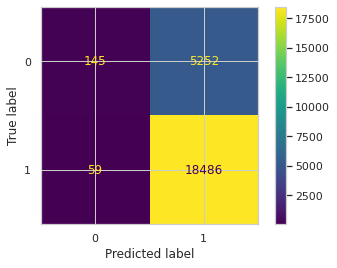

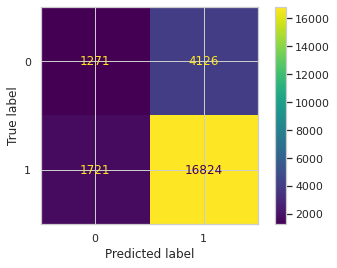

In [ ]:
#==============================
#===== TEST TF-IDF ML MODELS =====
#==============================

# MultinomialNB (alpha=1.0)
print(color.BOLD + "Naive Bayes (tf-idf)" + color.END)
nb = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=1.0))
                ])
nb.fit(X_train_preprocessed, y_train_sent)
y_pred = nb.predict(X_test_preprocessed)
plot_confusion_matrix(nb, X_test_preprocessed, y_test_sent)

metrics_nb = classification_report(y_test_sent, y_pred, output_dict=True) #y_true, y_pred
results_sentiment["NB(tfidf)"] = metrics_nb
print("Accuracy:")
pprint(results_sentiment["NB(tfidf)"]['accuracy'])
print("Weighted avg:")
pprint(results_sentiment["NB(tfidf)"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test_sent, y_pred))

# Logistic Regression
print(color.BOLD + "Logistic Regression (tf-idf)" + color.END)
logreg = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='sag'))
                ])
logreg.fit(X_train_preprocessed, y_train_sent)
y_pred = logreg.predict(X_test_preprocessed)
plot_confusion_matrix(logreg, X_test_preprocessed, y_test_sent)

metrics_logreg = classification_report(y_test_sent, y_pred, output_dict=True)
results_sentiment["LogReg(tfidf)"] = metrics_logreg
print("Accuracy:")
pprint(results_sentiment["LogReg(tfidf)"]['accuracy'])
print("Weighted avg:")
pprint(results_sentiment["LogReg(tfidf)"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test_sent, y_pred))

Support Vector Machines (tf-idf)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy:
0.7784646228385265
Weighted avg:
{'f1-score': 0.6951648670503513,
 'precision': 0.7458134922899702,
 'recall': 0.7784646228385265,
 'support': 23942}
Balanced Accuracy: 0.5177457813980816


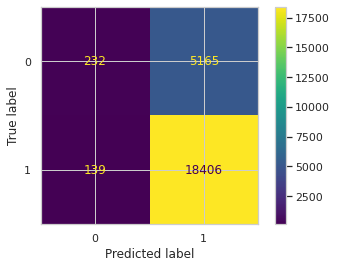

In [ ]:
# Support Vector Machines (kernel=linear)
print(color.BOLD + "Support Vector Machines (tf-idf)" + color.END)
clf = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', svm.SVC(kernel='linear'))
                ])
clf.fit(X_train_preprocessed, y_train_sent)
y_pred = clf.predict(X_test_preprocessed)
plot_confusion_matrix(clf, X_test_preprocessed, y_test_sent)


metrics_svm = classification_report(y_test_sent, y_pred, output_dict=True)
results_sentiment["SVM(tfidf)"] = metrics_svm
print("Accuracy:")
pprint(results_sentiment["SVM(tfidf)"]['accuracy'])
print("Weighted avg:")
pprint(results_sentiment["SVM(tfidf)"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test_sent, y_pred))

Support Vector Machines (Doc2Vec)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy:
0.7745802355692925
Weighted avg:
{'f1-score': 0.6761875617780747,
 'precision': 0.5999745413345806,
 'recall': 0.7745802355692925,
 'support': 23942}
Balanced Accuracy: 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


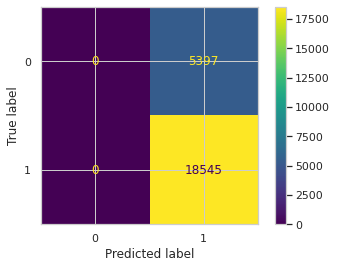

In [ ]:
# SVM with Doc2Vec, kernel=linear
print(color.BOLD + "Support Vector Machines (Doc2Vec)" + color.END)
clf = svm.SVC(kernel='linear')
clf.fit(train_vectors_dbow, y_train_sent)
y_pred = clf.predict(test_vectors_dbow)
plot_confusion_matrix(clf, test_vectors_dbow, y_test_sent)

metrics_svm_doc2vec = classification_report(y_test_sent, y_pred, output_dict=True)
results_sentiment["SVM(doc2vec)"] = metrics_svm_doc2vec
print("Accuracy:")
pprint(results_sentiment["SVM(doc2vec)"]['accuracy'])
print("Weighted avg:")
pprint(results_sentiment["SVM(doc2vec)"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test_sent, y_pred))

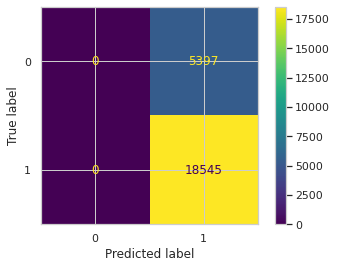

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_sent, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Unsupervised Vader Sentiment

In [ ]:
# ========== VADER SENTIMENT FUNCTIONS ==========
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    #print("{:-<40} {}".format(sentence, str(score)))
    return score

def is_positive(text):
    '''True if text has positive compound sentiment, False otherwise.'''
    sentiment_score = sentiment_analyzer_scores(text)

    if sentiment_score["compound"] > 0:
      return 1
    else:
      return 0

In [ ]:
# ========= VADER PREDICTIONS =========
print(color.BOLD + "Vader Sentiment" + color.END)
y_pred = [is_positive(text) for text in X_test]

#plot_confusion_matrix(clf, test_vectors_dbow, y_test_sent)

#cf_matrix = confusion_matrix(y_test_sent, y_pred)
#sns.heatmap(cf_matrix, annot=True, cmap='Blues')

metrics_vader_sent = classification_report(y_test_sent, y_pred, output_dict=True)
results_sentiment["vader_sent"] = metrics_vader_sent
print("Accuracy:")
pprint(results_sentiment["vader_sent"]['accuracy'])
print("Weighted avg:")
pprint(results_sentiment["vader_sent"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test_sent, y_pred))

Vader Sentiment
Accuracy:
0.5314092389942361
Weighted avg:
{'f1-score': 0.5685071132871802,
 'precision': 0.7008198474897821,
 'recall': 0.5314092389942361,
 'support': 23942}
Balanced Accuracy: 0.5690443494041431


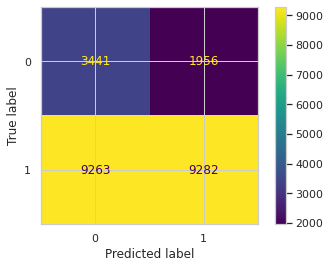

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_sent, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Save results (classical machine learning sentiment classification)

In [ ]:
# ========= SENTIMENT PREDICTIONS =========
#model_names = ['NB (tfidf)', 'SVM (tf-idf)', 'LogReg (tf-idf)', 'SVM (doc2vec)', 'Vader']

results_sentiment_df = pd.DataFrame(results_sentiment).transpose()

writer = pd.ExcelWriter(path_results+'results_sentiment_review_level.xlsx')

results_sentiment_df.to_excel(writer, sheet_name="sentiment_analysis")

writer.save()

In [ ]:
results_sentiment_df = pd.DataFrame(results_sentiment).transpose()

writer = pd.ExcelWriter(path_results+'results_sentiment_sentence_level.xlsx')

results_sentiment_df.to_excel(writer, sheet_name="sentiment_analysis")

writer.save()

## BERT

In [ ]:
# ========= PRE-PROCESS WITH BERT =========
def BERT_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# ========= TOKENIZATION =========
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=BERT_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# ========= SPECIFY MAX LENGTH OF SENTENCES =========

# Concatenate train data and test data
all_reviews = np.concatenate([train_data_cleaned[:17946].Text.values, test_data_cleaned[:17946].Text.values])

# Encode our concatenated data
encoded_reviews = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_reviews]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_reviews])
print('Max length: ', max_len)

# Specify `MAX_LEN`
MAX_LEN = 298

# Print sentence 0 and its encoded token ids
#token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
#print('Original: ', X[0])
#print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train[:17946])
test_inputs, test_masks = preprocessing_for_bert(X_test[:17946])

Max length:  298
Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# ========= CONVERT DATA TO TORCH TENSORS =========
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train_sent[:17946])
test_labels = torch.tensor(y_test_sent[:17946])

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 2

# Create the DataLoader for our training set
train_data_bert = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data_bert)
train_dataloader = DataLoader(train_data_bert, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
test_data_bert = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data_bert)
test_dataloader = DataLoader(test_data_bert, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# ========= BERT CLASSIFIER =========
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
# ========= OPTIMIZER AND TRAINING SCHEDULER =========
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
# ========= LOSS FUNCTION =========
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")

# ========= EVALUATE =========
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
! pip install nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 297 kB 7.2 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=3f890224fddacde0eced37330b10dba338660a80fbd4ae493ccfd5f69994c376
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils
  Attempting uninstall: pluggy
    Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Attempting uninstall: pytest
    Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3

In [ ]:
sudo kill -9 pid

In [ ]:
# ========= TRAINING =========
set_seed(42)    # Set seed for reproducibility 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, test_dataloader, epochs=2, evaluation=True)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.648373   |     -      |     -     |   2.98   
   1    |   40    |   0.602256   |     -      |     -     |   2.70   
   1    |   60    |   0.807362   |     -      |     -     |   2.71   
   1    |   80    |   0.746811   |     -      |     -     |   2.72   
   1    |   100   |   0.152547   |     -      |     -     |   2.73   
   1    |   120   |   0.911915   |     -      |     -     |   2.73   
   1    |   140   |   0.702497   |     -      |     -     |   2.75   
   1    |   160   |   0.762252   |     -      |     -     |   2.74   
   1    |   180   |   0.577524   |     -      |     -     |   2.75   
   1    |   200   |   0.710038   |     -      |     -     |   2.75   
   1    |   220   |   0.413285   |     -      |     -     |   2.76   
   1    |   240   |   0.870043   |     -      |     -     |   2.77   


In [ ]:
# ========= EVALUATE ROC =========
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr) 
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
# ========= MAKE PREDICTIONS =========
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:[:]
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs
  
# Compute predicted probabilities on the val set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test_sent[:17946])

ValueError: ignored

AUC: 0.5005
Accuracy: 77.82%


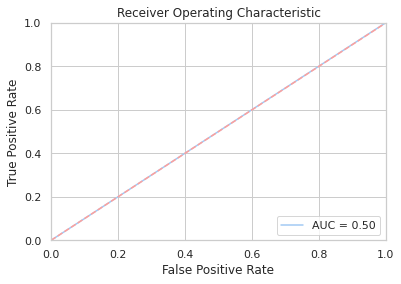

In [ ]:
# Evaluate the Bert classifier
evaluate_roc(probs, y_test_sent[:17946])

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data_cleaned.Text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Nr. of non-neg reviews
print("Number of reviews positive", test_data_cleaned[:17946][test_data_cleaned["Label"]==1].shape[0])
print("Number of reviews negative", test_data_cleaned[:17946][test_data_cleaned["Label"]==0].shape[0])

Number of reviews positive 13966
Number of reviews negative 3980


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

In [ ]:
print(probs)

[[0.05104135 0.9489587 ]
 [0.05104132 0.9489587 ]
 [0.05104132 0.9489587 ]
 ...
 [0.05104133 0.9489587 ]
 [0.05104132 0.9489587 ]
 [0.05104133 0.9489587 ]]


Number of reviews predicted positive:  23942
AUC: 0.5003
Accuracy: 77.46%


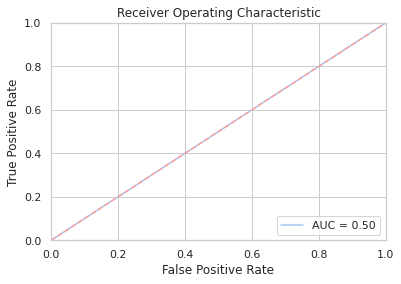

In [ ]:
# Get predictions from the probabilities
threshold = 0.94
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of reviews predicted positive: ", preds.sum())

# Evaluate the Bert classifier
results_sentiment['BERT_Eval'] = evaluate_roc(probs, test_data_cleaned.Label)

In [ ]:
print(classification_report(y_test_sent[:17946],preds[:17946]))
print("Balanced Accuracy:", balanced_accuracy_score(y_test_sent[:17946],preds[:17946]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3980
           1       0.78      1.00      0.88     13966

    accuracy                           0.78     17946
   macro avg       0.39      0.50      0.44     17946
weighted avg       0.61      0.78      0.68     17946

Balanced Accuracy: 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(test_data_cleaned.Label, preds)
print(cf_matrix)

[[ 393 1240]
 [1265 5157]]


In [ ]:
#results_sentiment['BERT'] = {"Number of reviews predicted non-negative": 6321, "AUC": 0.8449, "Accuracy": 0.8426}

[[ 393 1240]
 [1265 5157]]


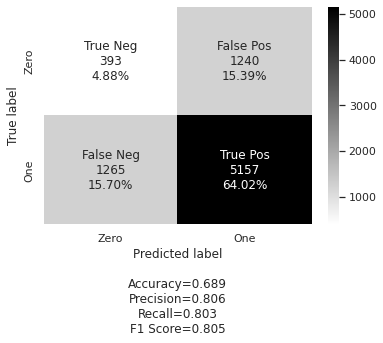

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(test_data_cleaned.Label, preds)
print(cf_matrix)

labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Zero", "One"]

# Metrics
accuracy, precision, recall, f1_score = make_confusion_matrix(cf_matrix, 
                                                              group_names=labels,
                                                              categories=categories, 
                                                              cmap='binary')
results_sentiment["BERT"] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score':f1_score}

## Save results (BERT sentiment classification)

In [ ]:
results_sentiment_df = pd.DataFrame(results_sentiment, index=[0]).transpose()

writer = pd.ExcelWriter(path_results+'results_sentiment_sentencelevel.xlsx')

results_sentiment_df.to_excel(writer, sheet_name="sentiment_analysis")

writer.save()

NameError: name 'path_results' is not defined

## Final Sentiment Predictions

In [ ]:
# Final predictions on test data from best model
sent_pred_final = preds

# Extractive Summarisation

In [ ]:
# Concatenate all data together

all_data = pd.concat([train_data_cleaned, val_data_cleaned, test_data_cleaned])

# Original labels
all_data_og = all_data
#test_data_og = test_data_cleaned

# Predicted labels
all_data_pred = all_data.copy()

all_data_pred["Aspect"] = aspect_pred_final
all_data_pred["Label"] = sent_pred_final
#test_data_pred = test_data_cleaned.copy()
#test_data_pred["Aspect"] = aspect_pred_final
#test_data_pred["Label"] = sent_pred_final

print("Shape of all_data: ", all_data.shape[0])
print("Shape of test_data_cleaned: ", test_data_cleaned.shape[0])

Shape of all_data:  40024
Shape of test_data_cleaned:  8055


## Create input documents

OG = original labels
Pred = predicted labels

### All data

In [ ]:
# ALL DATA OG
all_data_og = pd.DataFrame(columns=["Venue", "Aspect", "Sentiment", "Input", "Summary"])
temp_df = pd.DataFrame(columns=["Venue", "Aspect", "Sentiment", "Input", "Summary"])
venue_lst = []
aspect_lst = []
sent_lst = []
input_lst = []


for v in all_data["Venue"].unique():
    venue_df = all_data[all_data["Venue"]==v]
    for a in venue_df["Aspect"].unique():
        aspect_df = venue_df[venue_df["Aspect"]==a]
        for sent in aspect_df["Sentiment"].unique():
            sent_df = aspect_df[aspect_df["Sentiment"]==sent]
            input = ' '.join(sent_df.Text).replace('\n', '').replace('.', '. ').replace('  ', ' ')
            # Count nr. of sentences in the input and set a threshold of 6 sentences
            if len(sent_tokenize(input)) > 6:
                venue_lst.append(v)
                aspect_lst.append(a)
                sent_lst.append(sent)
                input_lst.append(input)

all_data_og["Venue"] = venue_lst
all_data_og["Aspect"] = aspect_lst
all_data_og["Sentiment"] = sent_lst
all_data_og["Input"] = input_lst

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Venue-Accessibility-NLP/Results/all_data_og.xlsx')

all_data_og.to_excel(writer, sheet_name="summary_text")

writer.save()

In [ ]:
# ALL DATA PRED
all_data_pred = pd.DataFrame(columns=["Venue", "Aspect", "Sentiment", "Input", "Summary"])
temp_df = pd.DataFrame(columns=["Venue", "Aspect", "Sentiment", "Input", "Summary"])
venue_lst = []
aspect_lst = []
sent_lst = []
input_lst = []


for v in all_data_pred["Venue"].unique():
    venue_df = all_data_pred[all_data["Venue"]==v]
    for a in venue_df["Aspect"].unique():
        aspect_df = venue_df[venue_df["Aspect"]==a]
        for sent in aspect_df["Sentiment"].unique():
            sent_df = aspect_df[aspect_df["Sentiment"]==sent]
            input = ' '.join(sent_df.Text).replace('\n', '').replace('.', '. ').replace('  ', ' ')
            # Count nr. of sentences in the input and set a threshold of 6 sentences
            if len(sent_tokenize(input)) > 6:
                venue_lst.append(v)
                aspect_lst.append(a)
                sent_lst.append(sent)
                input_lst.append(input)

all_data_pred["Venue"] = venue_lst
all_data_pred["Aspect"] = aspect_lst
all_data_pred["Sentiment"] = sent_lst
all_data_pred["Input"] = input_lst

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Venue-Accessibility-NLP/Results/all_data_pred.xlsx')

all_data_pred.to_excel(writer, sheet_name="summary_text")

writer.save()

3461

### Test data

In [ ]:
# TEST DATA OG
test_data_og = pd.DataFrame(columns=["Venue", "Aspect", "Sentiment", "Input", "Summary"])
temp_df = pd.DataFrame(columns=["Venue", "Aspect", "Sentiment", "Input", "Summary"])
venue_lst = []
aspect_lst = []
sent_lst = []
input_lst = []


for v in test_data_cleaned["Venue"].unique():
    venue_df = test_data_cleaned[test_data_cleaned["Venue"]==v]
    for a in venue_df["Aspect"].unique():
        aspect_df = venue_df[venue_df["Aspect"]==a]
        for sent in aspect_df["Sentiment"].unique():
            sent_df = aspect_df[aspect_df["Sentiment"]==sent]
            input = ' '.join(sent_df.Text).replace('\n', '').replace('.', '. ').replace('  ', ' ')
            # Count nr. of sentences in the input and set a threshold of 6 sentences
            if len(sent_tokenize(input)) > 10:
                venue_lst.append(v)
                aspect_lst.append(a)
                sent_lst.append(sent)
                input_lst.append(input)

test_data_og["Venue"] = venue_lst
test_data_og["Aspect"] = aspect_lst
test_data_og["Sentiment"] = sent_lst
test_data_og["Input"] = input_lst

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/test_data_og.xlsx')

test_data_og.to_excel(writer, sheet_name="summary_text")

writer.save()

In [ ]:
# TEST DATA PRED
test_data_pred = pd.DataFrame(columns=["Venue", "Aspect", "Sentiment", "Input", "Gensim_summary"])
temp_df = pd.DataFrame(columns=["Venue", "Aspect", "Sentiment", "Input", "Gensim_summary"])
venue_lst = []
aspect_lst = []
sent_lst = []
input_lst = []

test_data_pred = 

for v in test_data_pred["Venue"].unique():
    venue_df = test_data_pred[test_data_cleaned["Venue"]==v]
    for a in venue_df["Aspect"].unique():
        aspect_df = venue_df[venue_df["Aspect"]==a]
        for sent in aspect_df["Sentiment"].unique():
            sent_df = aspect_df[aspect_df["Sentiment"]==sent]
            input = ' '.join(sent_df.Text).replace('\n', '').replace('.', '. ').replace('  ', ' ')
            # Count nr. of sentences in the input and set a threshold of 6 sentences
            if len(sent_tokenize(input)) > 10:
                venue_lst.append(v)
                aspect_lst.append(a)
                sent_lst.append(sent)
                input_lst.append(input)

test_data_pred["Venue"] = venue_lst
test_data_pred["Aspect"] = aspect_lst
test_data_pred["Sentiment"] = sent_lst
test_data_pred["Input"] = input_lst

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/test_data_pred.xlsx')

test_data_pred.to_excel(writer, sheet_name="summary_text")

writer.save()

## Evaluation

In [ ]:
# ========== SUMMARY EVALUATION ==========

# Creating a dictionary and corpus
def create_corpus(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Isolate and remove punctuations
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    - Create dictionary
    - Create corpus
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations
    s = re.sub(r'[^\w\s]','',s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    tokens = word_tokenize(s)

    dictionary = Dictionary([tokens])

    corpus = [dictionary.doc2bow(text) for text in [tokens]]

    return dictionary, corpus

# Evaluate with Distance Metrics (Kullback-Leibler and Jensen Shannon)
def distance_metrics(input, output):
    stop_words = stopwords.words('english')
    dictionary, corpus = create_corpus(input)

    np.random.seed(1)

    model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=2, minimum_probability=1e-8)

    input_lst = [word for word in word_tokenize(input) if not word.lower() in stop_words]
    output_lst = [word for word in word_tokenize(output) if not word.lower() in stop_words]

    # now let's make these into a bag of words format
    bow_input = model.id2word.doc2bow(input_lst)
    bow_output = model.id2word.doc2bow(output_lst)

    # we can now get the LDA topic distributions for these
    lda_input = model[bow_input]
    lda_output = model[bow_output]

    kull = kullback_leibler(lda_input, lda_output)

    jens = distance.jensenshannon(lda_input, lda_output)

    return kull, jens[1]

## TextRank

In [ ]:
# ALL DATA OG
gensim_summaries_all_data = all_data_og.copy()

output_lst = []

for input in gensim_summaries_all_data["Input"]:
    nr_words = (len(word_tokenize(input)))
 
    try:
        output = summarize(input, word_count=50).replace('\n', '').replace('.', '. ')
        if output == '':
            output = input
    except:
        output_lst.append(input)
    else:
        output_lst.append(output)

gensim_summaries_all_data["Summary"] = output_lst

In [ ]:
# Evaluate gensim summaries
input_lst = gensim_summaries_all_data["Input"]
output_lst = gensim_summaries_all_data["Summary"]

kull_lst = []
jens_lst = []

for i in range(len(input_lst)):
    try:
        kull, jens = distance_metrics(input_lst[i], output_lst[i])
    except:
        kull, jens = -1, -1
        kull_lst.append(kull)
        jens_lst.append(jens)
    else:
        kull_lst.append(kull)
        jens_lst.append(jens)

gensim_summaries_all_data["kullback_leibler"] = kull_lst
gensim_summaries_all_data["jensen_shannon"] = jens_lst

In [ ]:
# With original labels
writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/gensim_summaries_all_data.xlsx')

all_data_og.to_excel(writer, sheet_name="summaries")

writer.save()

In [ ]:
# ALL DATA PRED
gensim_summaries_pred = all_data_pred.copy()

output_lst = []

for input in gensim_summaries_pred["Input"]:
    nr_words = (len(word_tokenize(input)))
 
    try:
        output = summarize(input, word_count=50).replace('\n', '').replace('.', '. ')
        if output == '':
            output = input
    except:
        output_lst.append(input)
    else:
        output_lst.append(output)

gensim_summaries_pred["Summary"] = output_lst

In [ ]:
# Evaluate gensim summaries
input_lst = gensim_summaries_pred["Input"]
output_lst = gensim_summaries_pred["Summary"]

kull_lst = []
jens_lst = []

for i in range(len(input_lst)):
    try:
        kull, jens = distance_metrics(input_lst[i], output_lst[i])
    except:
        kull, jens = -1, -1
        kull_lst.append(kull)
        jens_lst.append(jens)
    else:
        kull_lst.append(kull)
        jens_lst.append(jens)

gensim_summaries_pred["kullback_leibler"] = kull_lst
gensim_summaries_pred["jensen_shannon"] = jens_lst

## BERT

In [ ]:
# Initialize models
model_bert = Summarizer()
model_distilbert = Summarizer('distilbert-base-uncased', hidden=[-1,-2], hidden_concat=True)
model_sbert = SBertSummarizer('paraphrase-MiniLM-L6-v2')

### BERT Summarizer

In [ ]:
# ALL DATA OG
bert_summaries_og = all_data_og[["Venue", "Aspect", "Sentiment", "Input"]]

output_lst = []

for input in bert_summaries_og["Input"]:
    nr_words = (len(word_tokenize(input)))
 
    try:
        output = model_bert(input, num_sentences=3).replace('\n', '').replace('.', '. ')
        if output == '':
            output = input
    except:
        output_lst.append(input)
    else:
        output_lst.append(output)

bert_summaries_og["Summary"] = output_lst

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Venue-Accessibility-NLP/Results/bert_summaries_og.xlsx')

bert_summaries_og.to_excel(writer, sheet_name="summaries")

writer.save()

In [ ]:
# ALL DATA PRED
bert_summaries_pred = all_data_pred[["Venue", "Aspect", "Sentiment", "Input"]]

output_lst = []

for input in all_data_pred["Input"]:
    nr_words = (len(word_tokenize(input)))
 
    try:
        output = model_bert(input, num_sentences=3).replace('\n', '').replace('.', '. ')
        if output == '':
            output = input
    except:
        output_lst.append(input)
    else:
        output_lst.append(output)

bert_summaries_pred["Summary"] = output_lst

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Venue-Accessibility-NLP/Results/bert_summaries_pred.xlsx')

bert_summaries_pred.to_excel(writer, sheet_name="summaries")

writer.save()

### Distil BERT

In [ ]:
# ALL DATA OG

distilbert_summaries_og = all_data_og[["Venue", "Aspect", "Sentiment", "Input"]]

output_lst = []

for input in distilbert_summaries_og["Input"]:
    nr_words = (len(word_tokenize(input)))
 
    try:
        output = model_distilbert(input, num_sentences=3).replace('\n', '').replace('.', '. ')
        if output == '':
            output = input
    except:
        output_lst.append(input)
    else:
        output_lst.append(output)

distilbert_summaries_og["Summary"] = output_lst

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Venue-Accessibility-NLP/Results/distilbert_summaries_og.xlsx')

distilbert_summaries_og.to_excel(writer, sheet_name="summaries")

writer.save()

In [ ]:
# ALL DATA PRED

distilbert_summaries_pred = all_data_pred[["Venue", "Aspect", "Sentiment", "Input"]]

output_lst = []

for input in all_data_pred["Input"]:
    nr_words = (len(word_tokenize(input)))
 
    try:
        output = model_distilbert(input, num_sentences=3).replace('\n', '').replace('.', '. ')
        if output == '':
            output = input
    except:
        output_lst.append(input)
    else:
        output_lst.append(output)

distilbert_summaries_pred["Summary"] = output_lst

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Venue-Accessibility-NLP/Results/distilbert_summaries_pred.xlsx')

distilbert_summaries_pred.to_excel(writer, sheet_name="summaries")

writer.save()

### SBERT

In [ ]:
# ALL DATA OG

sbert_summaries_og = all_data_og[["Venue", "Aspect", "Sentiment", "Input"]]

output_lst = []

for input in sbert_summaries["Input"]:
    nr_words = (len(word_tokenize(input)))
 
    try:
        output = model_sbert(input, num_sentences=3).replace('\n', '').replace('.', '. ')
        if output == '':
            output = input
    except:
        output_lst.append(input)
    else:
        output_lst.append(output)

sbert_summaries_og["Summary"] = output_lst

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Venue-Accessibility-NLP/Results/sbert_summaries_og.xlsx')

sbert_summaries_og.to_excel(writer, sheet_name="summaries")

writer.save()

In [ ]:
# ALL DATA PRED

sbert_summaries_pred = all_data_pred[["Venue", "Aspect", "Sentiment", "Input"]]

output_lst = []

for input in sbert_summaries_pred["Input"]:
    nr_words = (len(word_tokenize(input)))
 
    try:
        output = model_sbert(input, num_sentences=3).replace('\n', '').replace('.', '. ')
        if output == '':
            output = input
    except:
        output_lst.append(input)
    else:
        output_lst.append(output)

sbert_summaries_pred["Summary"] = output_lst

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Venue-Accessibility-NLP/Results/sbert_summaries_pred.xlsx')

sbert_summaries_pred.to_excel(writer, sheet_name="summaries")

writer.save()

## Save all summaries

## Evaluation of summaries

In [ ]:
# Confusion matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    
    return accuracy, precision, recall, f1_score

In [ ]:
path = "/content/drive/MyDrive/Colab_Notebooks/Venue-Accessibility-NLP/Results/"
gensim_summaries_all_data = pd.read_excel(path + 'gensim_summaries_all_data.xlsx').rename(columns={"Unnamed: 0": "Index"})
bert_summaries_og = pd.read_excel(path + 'bert_summaries_og.xlsx').rename(columns={"Unnamed: 0": "Index"})
distilbert_summaries_og = pd.read_excel(path + 'distilbert_summaries_og.xlsx').rename(columns={"Unnamed: 0": "Index"})
sbert_summaries_og = pd.read_excel(path + 'sbert_summaries_og.xlsx').rename(columns={"Unnamed: 0": "Index"})

In [ ]:
gensim_summaries_all_data.head()

,Index,Venue,Aspect,Sentiment,Input,Summary,kullback_leibler,jensen_shannon,Target,Label
0,0.0,leuchie house north berwick,Transport & Parking,positive,Ample parking spaces and space. It is a beauti...,There is ample parking including disabled park...,0.008352,0.049038,2,1
1,1.0,leuchie house north berwick,Access,positive,Disabled access is very good. Although Leuchi...,They had to use lift to 2nd and 3rd floor From...,0.027544,0.078816,1,1
2,2.0,leuchie house north berwick,Overview,positive,Grace staff/venue/quality of care. Within 24 h...,The staff and volunteers at Leuchie did all th...,0.023189,0.077067,0,1
3,3.0,leuchie house north berwick,Staff,positive,All the staff and volunteers were very helpful...,All the staff and volunteers were very helpful...,0.013550,0.064499,4,1
4,4.0,leuchie house north berwick,Toilets,positive,All loos are accessible with plenty of room fo...,On the lower ground level there is a second to...,0.016822,0.070738,3,1


In [ ]:
def summary_metrics(df):

    # KL
    average_KL = np.mean(df["kullback_leibler"])
    max_KL = np.max(df["kullback_leibler"])
    min_KL = np.min(df["kullback_leibler"])

    # JS
    average_JS = np.mean(df["jensen_shannon"])
    max_JS = np.max(df["jensen_shannon"])
    min_JS = np.min(df["jensen_shannon"])

    metric_KL = {"KL": {'average': average_KL, 'max': max_KL, 'min': min_KL}}
    metric_JS = {"JS": {'average': average_JS, 'max': max_JS, 'min': min_JS}}

    return metric_KL, metric_JS

In [ ]:
results_genism = summary_metrics(gensim_summaries_all_data)
print(results_genism)

# Find metrics per sentiment
results_genism_sent = {}
results_genism_sent['positive'] = {}
results_genism_sent['negative'] = {}
for s in gensim_summaries_all_data["Sentiment"].unique():
    dff = gensim_summaries_all_data[gensim_summaries_all_data["Sentiment"] == s]

    results_genism_sent[s] = summary_metrics(dff)

print(results_genism_sent)

# Find metrics per aspect
results_genism_aspect = {}
results_genism_aspect['Overview'] = {}
results_genism_aspect['Access'] = {}
results_genism_aspect['Transport & Parking'] = {}
results_genism_aspect['Staff'] = {}
results_genism_aspect['Toilets'] = {}
for a in gensim_summaries_all_data["Aspect"].unique():
    dff = gensim_summaries_all_data[gensim_summaries_all_data["Aspect"] == a]

    results_genism_aspect[a] = summary_metrics(dff)

print(results_genism_aspect)

({'KL': {'average': 0.05768429194317113, 'max': 1.604149699211121, 'min': -8.195547707146034e-08}}, {'JS': {'average': 0.08937353879465376, 'max': 0.5659863625155918, 'min': 4.046577937640532e-06}})
{'positive': ({'KL': {'average': 0.054856697101191974, 'max': 1.604149699211121, 'min': -8.195547707146034e-08}}, {'JS': {'average': 0.08705338186047495, 'max': 0.5659863625155918, 'min': 4.046577937640532e-06}}), 'negative': ({'KL': {'average': 0.06919767812025547, 'max': 0.9892755746841431, 'min': 6.669779395451769e-09}}, {'JS': {'average': 0.09882074190100286, 'max': 0.4869386848633934, 'min': 6.133202794081434e-06}})}
{'Overview': ({'KL': {'average': 0.06505180658461461, 'max': 1.604149699211121, 'min': -8.195547707146034e-08}}, {'JS': {'average': 0.09327443740124605, 'max': 0.5659863625155918, 'min': 4.046577937640532e-06}}), 'Access': ({'KL': {'average': 0.05395926310703567, 'max': 1.187363862991333, 'min': 6.100744940340519e-07}}, {'JS': {'average': 0.08986685572485109, 'max': 0.5274

In [ ]:
results_BERT = summary_metrics(bert_summaries_all_data)
print(results_BERT)

# Find metrics per sentiment
results_BERT_sent = {}
results_BERT_sent['positive'] = {}
results_BERT_sent['negative'] = {}
for s in bert_summaries_all_data["Sentiment"].unique():
    dff = bert_summaries_all_data[bert_summaries_all_data["Sentiment"] == s]

    results_BERT_sent[s] = summary_metrics(dff)

print(results_BERT_sent)

# Find metrics per aspect
results_BERT_aspect = {}
results_BERT_aspect['Overview'] = {}
results_BERT_aspect['Access'] = {}
results_BERT_aspect['Transport & Parking'] = {}
results_BERT_aspect['Staff'] = {}
results_BERT_aspect['Toilets'] = {}
for a in bert_summaries_all_data["Aspect"].unique():
    dff = bert_summaries_all_data[bert_summaries_all_data["Aspect"] == a]

    results_BERT_aspect[a] = summary_metrics(dff)

print(results_BERT_aspect)

({'KL': {'average': 0.05304648787157036, 'max': 1.556218504905701, 'min': 7.660128176212311e-08}}, {'JS': {'average': 0.08701570241003759, 'max': 0.6050127450117583, 'min': 0.0001714768702973009}})
{'positive': ({'KL': {'average': 0.05165947157991615, 'max': 1.353567004203796, 'min': 7.660128176212311e-08}}, {'JS': {'average': 0.08679695785955562, 'max': 0.5081122510727576, 'min': 0.0001714768702973009}}), 'negative': ({'KL': {'average': 0.058694133695023944, 'max': 1.556218504905701, 'min': 9.915675036609173e-06}}, {'JS': {'average': 0.08790638534892373, 'max': 0.6050127450117583, 'min': 0.001573955635562067}})}
{'Overview': ({'KL': {'average': 0.053394360151036914, 'max': 1.353567004203796, 'min': 8.373608579859138e-07}}, {'JS': {'average': 0.08811701302466697, 'max': 0.5017598447241469, 'min': 0.0004386071688557312}}), 'Access': ({'KL': {'average': 0.057192878460344404, 'max': 1.556218504905701, 'min': 3.181630745530128e-06}}, {'JS': {'average': 0.08892197644370411, 'max': 0.6050127

In [ ]:
results_distilbert = summary_metrics(distilbert_summaries_all_data)
print(results_distilbert)

# Find metrics per sentiment
results_distilbert_sent = {}
results_distilbert_sent['positive'] = {}
results_distilbert_sent['negative'] = {}
for s in distilbert_summaries_all_data["Sentiment"].unique():
    dff = distilbert_summaries_all_data[distilbert_summaries_all_data["Sentiment"] == s]

    results_distilbert_sent[s] = summary_metrics(dff)

print(results_distilbert_sent)

# Find metrics per aspect
results_distilbert_aspect = {}
results_distilbert_aspect['Overview'] = {}
results_distilbert_aspect['Access'] = {}
results_distilbert_aspect['Transport & Parking'] = {}
results_distilbert_aspect['Staff'] = {}
results_distilbert_aspect['Toilets'] = {}
for a in distilbert_summaries_all_data["Aspect"].unique():
    dff = distilbert_summaries_all_data[distilbert_summaries_all_data["Aspect"] == a]

    results_distilbert_aspect[a] = summary_metrics(dff)

print(results_distilbert_aspect)

({'KL': {'average': 0.051909250786357136, 'max': 1.239574551582336, 'min': 1.127773430198431e-08}}, {'JS': {'average': 0.08474577579077572, 'max': 0.5379023393362399, 'min': 0.0001182908506268736}})
{'positive': ({'KL': {'average': 0.05164204027968657, 'max': 1.239574551582336, 'min': 3.181630745530128e-06}}, {'JS': {'average': 0.08488462450237871, 'max': 0.5379023393362399, 'min': 0.0008933376026794914}}), 'negative': ({'KL': {'average': 0.05299727715710805, 'max': 1.230485916137695, 'min': 1.127773430198431e-08}}, {'JS': {'average': 0.08418041231891477, 'max': 0.5270421000022651, 'min': 0.0001182908506268736}})}
{'Overview': ({'KL': {'average': 0.05317202303302538, 'max': 1.142797231674194, 'min': 1.127773430198431e-08}}, {'JS': {'average': 0.08528237005133334, 'max': 0.4782676532433227, 'min': 0.0001182908506268736}}), 'Access': ({'KL': {'average': 0.05627821631092863, 'max': 1.230485916137695, 'min': 6.530026439577341e-07}}, {'JS': {'average': 0.08763588182369568, 'max': 0.53790233

In [ ]:
results_sbert = summary_metrics(sbert_summaries_all_data)
print(results_sbert)

# Find metrics per sentiment
results_sbert_sent = {}
results_sbert_sent['positive'] = {}
results_sbert_sent['negative'] = {}
for s in sbert_summaries_all_data["Sentiment"].unique():
    dff = sbert_summaries_all_data[sbert_summaries_all_data["Sentiment"] == s]

    results_sbert_sent[s] = summary_metrics(dff)

print(results_sbert_sent)

# Find metrics per aspect
results_sbert_aspect = {}
results_sbert_aspect['Overview'] = {}
results_sbert_aspect['Access'] = {}
results_sbert_aspect['Transport & Parking'] = {}
results_sbert_aspect['Staff'] = {}
results_sbert_aspect['Toilets'] = {}
for a in sbert_summaries_all_data["Aspect"].unique():
    dff = sbert_summaries_all_data[sbert_summaries_all_data["Aspect"] == a]

    results_sbert_aspect[a] = summary_metrics(dff)

print(results_sbert_aspect)

({'KL': {'average': 0.046995886971426475, 'max': 1.308675527572632, 'min': 1.127773430198431e-08}}, {'JS': {'average': 0.08157832564557359, 'max': 0.5351171816021756, 'min': 0.0001182908506268736}})
{'positive': ({'KL': {'average': 0.04478621368546026, 'max': 1.308675527572632, 'min': 3.192981239408255e-07}}, {'JS': {'average': 0.08091851601949909, 'max': 0.5232403827039235, 'min': 0.0002825170630808439}}), 'negative': ({'KL': {'average': 0.055993223325565805, 'max': 1.117371082305908, 'min': 1.127773430198431e-08}}, {'JS': {'average': 0.08426493509738409, 'max': 0.5351171816021756, 'min': 0.0001182908506268736}})}
{'Overview': ({'KL': {'average': 0.04634576374027163, 'max': 1.107050061225891, 'min': 1.127773430198431e-08}}, {'JS': {'average': 0.08036151371448211, 'max': 0.5232403827039235, 'min': 0.0001182908506268736}}), 'Access': ({'KL': {'average': 0.051137388642741706, 'max': 1.308675527572632, 'min': 6.787740858271718e-07}}, {'JS': {'average': 0.08515566227335811, 'max': 0.522912

In [ ]:
results_summaries = {}
results_summaries['Gensim'] = results_genism
results_summaries['Gensim_sentiment'] = results_genism_sent
results_summaries['Gensim_aspect'] = results_genism_aspect

results_summaries['BERT'] = results_BERT
results_summaries['BERT_sentiment'] = results_BERT_sent
results_summaries['BERT_aspect'] = results_BERT_aspect

results_summaries['distilBERT'] = results_distilbert
results_summaries['distilBERT_sentiment'] = results_distilbert_sent
results_summaries['distilBERT_aspect'] = results_distilbert_aspect

results_summaries['SBERT'] = results_sbert
results_summaries['SBERT_sentiment'] = results_sbert_sent
results_summaries['SBERT_aspect'] = results_sbert_aspect

with open('/content/drive/MyDrive/Colab_Notebooks/Venue-Accessibility-NLP/Results/results_summaries.csv', 'w') as f:
  for key in results_summaries.keys():
    f.write("%s,%s\n"%(key,results_summaries[key]))

#results_summaries_df = pd.DataFrame(results_summaries.Transpose())

#writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Venue-Accessibility-NLP/Results/results_summaries.xlsx')

#results_summaries_df.to_excel(writer, sheet_name="results_summaries")

#writer.save()

In [ ]:
results_summaries

{'BERT': ({'KL': {'average': 0.05304648787157036,
    'max': 1.556218504905701,
    'min': 7.660128176212311e-08}},
  {'JS': {'average': 0.08701570241003759,
    'max': 0.6050127450117583,
    'min': 0.0001714768702973009}}),
 'BERT_aspect': {'Access': ({'KL': {'average': 0.057192878460344404,
     'max': 1.556218504905701,
     'min': 3.181630745530128e-06}},
   {'JS': {'average': 0.08892197644370411,
     'max': 0.6050127450117583,
     'min': 0.0008933376026794914}}),
  'Overview': ({'KL': {'average': 0.053394360151036914,
     'max': 1.353567004203796,
     'min': 8.373608579859138e-07}},
   {'JS': {'average': 0.08811701302466697,
     'max': 0.5017598447241469,
     'min': 0.0004386071688557312}}),
  'Staff': ({'KL': {'average': 0.06012407550068539,
     'max': 0.7549422979354858,
     'min': 9.915675036609173e-06}},
   {'JS': {'average': 0.08868576532482579,
     'max': 0.4551891868961689,
     'min': 0.001573955635562067}}),
  'Toilets': ({'KL': {'average': 0.04516706006812318,


In [ ]:
# Find metrics per sentiment
results_genism_sent = {}
results_genism_sent['positive'] = {}
results_genism_sent['negative'] = {}
for s in gensim_summaries_all_data["Sentiment"].unique():
    dff = gensim_summaries_all_data[gensim_summaries_all_data["Sentiment"] == s]

    results_genism_sent[s] = summary_metrics(dff)

# Find metrics per aspect
results_genism_aspect = {}
results_genism_aspect['Overview'] = {}
results_genism_aspect['Access'] = {}
results_genism_aspect['Transport & Parking'] = {}
results_genism_aspect['Staff'] = {}
results_genism_aspect['Toilets'] = {}
for a in gensim_summaries_all_data["Aspect"].unique():
    dff = gensim_summaries_all_data[gensim_summaries_all_data["Sentiment"] == s]

    results_genism_aspect[a] = summary_metrics(dff)

In [ ]:
results_genism_sent

{'negative': ({'KL': {'average': 0.06919767812025547,
    'max': 0.9892755746841431,
    'min': 6.669779395451769e-09}},
  {'JS': {'average': 0.09882074190100286,
    'max': 0.4869386848633934,
    'min': 6.133202794081434e-06}}),
 'positive': ({'KL': {'average': 0.054856697101191974,
    'max': 1.604149699211121,
    'min': -8.195547707146034e-08}},
  {'JS': {'average': 0.08705338186047495,
    'max': 0.5659863625155918,
    'min': 4.046577937640532e-06}})}

In [ ]:
results_genism_aspect

{'Access': ({'KL': {'average': 0.06919767812025547,
    'max': 0.9892755746841431,
    'min': 6.669779395451769e-09}},
  {'JS': {'average': 0.09882074190100286,
    'max': 0.4869386848633934,
    'min': 6.133202794081434e-06}}),
 'Overview': ({'KL': {'average': 0.06919767812025547,
    'max': 0.9892755746841431,
    'min': 6.669779395451769e-09}},
  {'JS': {'average': 0.09882074190100286,
    'max': 0.4869386848633934,
    'min': 6.133202794081434e-06}}),
 'Staff': ({'KL': {'average': 0.06919767812025547,
    'max': 0.9892755746841431,
    'min': 6.669779395451769e-09}},
  {'JS': {'average': 0.09882074190100286,
    'max': 0.4869386848633934,
    'min': 6.133202794081434e-06}}),
 'Toilets': ({'KL': {'average': 0.06919767812025547,
    'max': 0.9892755746841431,
    'min': 6.669779395451769e-09}},
  {'JS': {'average': 0.09882074190100286,
    'max': 0.4869386848633934,
    'min': 6.133202794081434e-06}}),
 'Transport & Parking': ({'KL': {'average': 0.06919767812025547,
    'max': 0.9892

In [ ]:
!pip freeze > requirements.txt